In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, re, gc, glob, pickle
import torch
from torch.utils.data import DataLoader, Dataset
from utils import DatasetBuilder, JDIDataset, JDIModel, get_grey_image
from tqdm.auto import tqdm, trange
from time import sleep
from utils import maximize_window

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib inline

2021-03-10 04:29:44,979 - INFO - dataset:dataset.py:24 - dataset package is loaded...


- ## Specify URL and name of dataset

In [2]:
URL = 'https://www.epam.com/'
DATASET_NAME = 'epam'

URL = 'https://pytorch.org/'
DATASET_NAME = 'pytorch'

# URL = 'https://www.tensorflow.org/'
# DATASET_NAME = 'tensorflow'

URL = 'https://www.cnews.ru/'
DATASET_NAME = 'cnews'

- ## Build dataset: Retrieve data, create image, detect sensible elements

In [3]:
# %%time

# class EPAMDatasetBuilder(DatasetBuilder):
#     """
#         Custom dataset builder
#     """
#     def setUp(self, driver):
#         self.logger.info(f'getting page')
#         driver.set_window_size(1200, 1000, windowHandle='current')
#         driver.get(self.url)
#         sleep(5)
#         maximize_window(driver=driver)
#         sleep(5)

# with EPAMDatasetBuilder(url = URL, dataset_name=DATASET_NAME) as builder:
#     print(builder.dataset.shape)



In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

- ## Load pretrained model

In [5]:
model = torch.load('model/model.weights').to(DEVICE)
model.eval() # switch to "predict" mode

JDIModel(
  (input_layer): Linear(in_features=557, out_features=64, bias=False)
  (batchNorm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.01, inplace=True)
  (hidden1): Linear(in_features=64, out_features=32, bias=False)
  (batchNorm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.01, inplace=True)
  (hidden2): Linear(in_features=32, out_features=21, bias=True)
)

In [6]:
dataset = JDIDataset(dataset_names=[f'{DATASET_NAME}'], rebalance=False)

2021-03-10 04:29:47,336 - INFO - dataset:dataset.py:307 - Dataset for cnews
2021-03-10 04:29:47,407 - INFO - dataset:dataset.py:309 - Dataset shape: (2221, 23)
2021-03-10 04:29:47,408 - INFO - dataset:dataset.py:311 - cleaning tag_name from dummy words
2021-03-10 04:29:47,410 - WARNING - dataset:dataset.py:320 - LABELS: not loaded
2021-03-10 04:29:47,411 - INFO - dataset:dataset.py:52 - select all leafs (nodes which are not parents)
2021-03-10 04:29:47,412 - INFO - dataset:dataset.py:54 - Leafs set size: 1319 (nodes which have no children)
2021-03-10 04:29:47,414 - INFO - dataset:dataset.py:57 - count number of references to leafs
2021-03-10 04:29:47,417 - INFO - dataset:dataset.py:59 - Nodes with leafs as children set size: 678 (nodes which have leafs as children)
2021-03-10 04:29:47,420 - INFO - dataset:dataset.py:62 - count num children for each node
2021-03-10 04:29:47,422 - INFO - dataset:dataset.py:64 - Nodes with children: 903
2021-03-10 04:29:47,426 - INFO - dataset:dataset.py:

In [7]:
dataloader=DataLoader(dataset, shuffle=False, batch_size=1)

- ## Predict

In [8]:
with open('model/label_ohe.pkl', 'rb') as f:
    label_ohe = pickle.load(f)

results = []
with trange(len(dataloader)) as bar:
    with torch.no_grad():
        for x, y in dataloader:
           
            y_pred = torch.round(torch.nn.Softmax(dim=1)(model(x.to(DEVICE)).to('cpu'))).detach().numpy()
            #print(y_pred)
            
            y_true_label = label_ohe.inverse_transform(y).squeeze().squeeze()
            try:
                y_pred_label = label_ohe.inverse_transform(y_pred).squeeze().squeeze()
            except:
                y_pred_label = 'n/a'
            
            # print(y_pred, y_pred_label, y_true_label)
            
            results.append({
                'y_true': np.argmax(y).item(),
                'y_pred': np.argmax(y_pred),
                'y_true_label': y_true_label, 
                'y_pred_label': y_pred_label
            })
            bar.update(1)

results_df = pd.DataFrame(results)
results_df

  0%|          | 0/2221 [00:00<?, ?it/s]

,y_true,y_pred,y_true_label,y_pred_label
0,12,12,n/a,n/a
1,12,12,n/a,n/a
2,12,12,n/a,n/a
3,12,12,n/a,n/a
4,12,12,n/a,n/a
...,...,...,...,...
2216,12,12,n/a,n/a
2217,12,12,n/a,n/a
2218,12,12,n/a,n/a
2219,12,12,n/a,n/a


- ## Load labels if they available for the dataset 

In [9]:
dataset.dataset_copy_df.label_text
dataset.dataset_copy_df['label_text_predicted'] = results_df.y_pred_label
dataset.dataset_copy_df[['label_text', 'label_text_predicted']]

,label_text,label_text_predicted
0,n/a,n/a
1,n/a,n/a
2,n/a,n/a
3,n/a,n/a
4,n/a,n/a
...,...,...
2216,n/a,n/a
2217,n/a,n/a
2218,n/a,n/a
2219,n/a,n/a


- ## Evaluate: draw predictions

(8046, 1183)


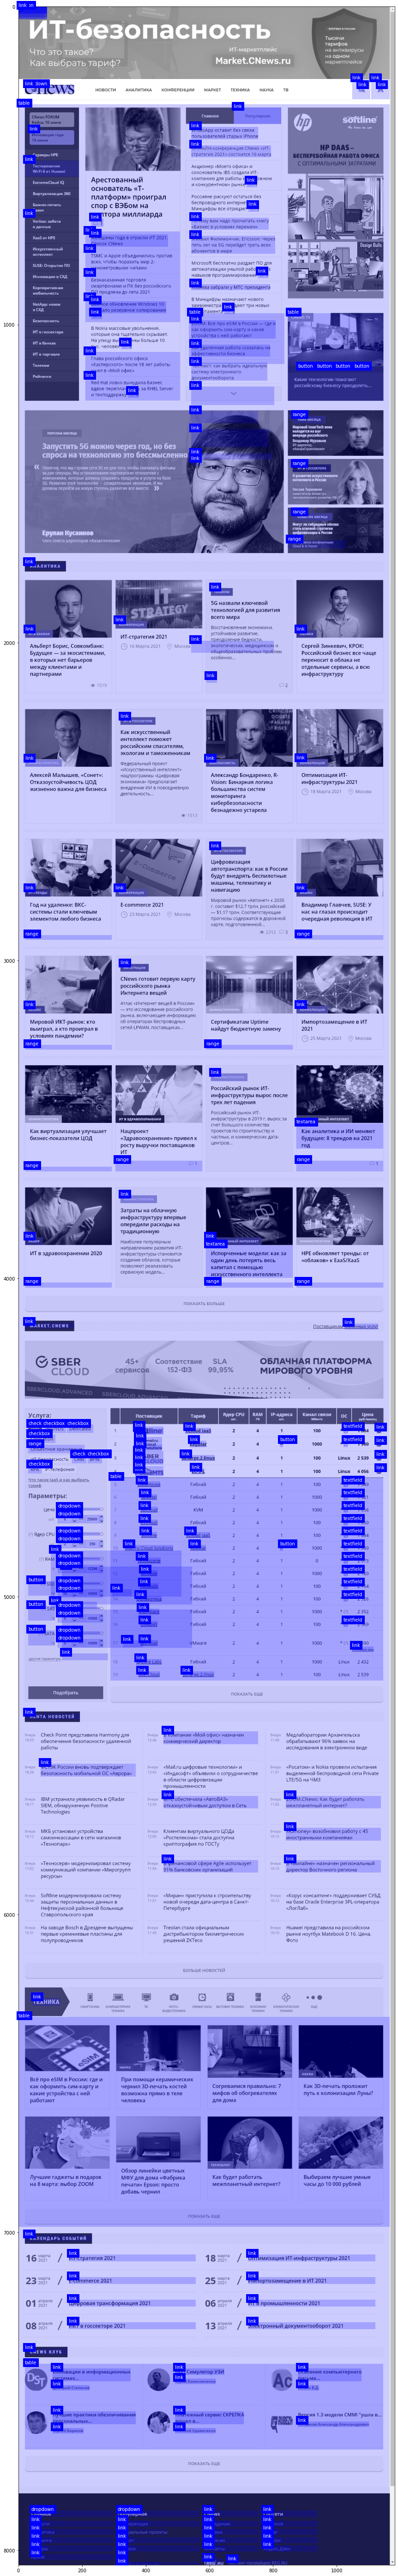

In [10]:
gray_img = get_grey_image(f'dataset/images/{DATASET_NAME}.png')
print(gray_img.shape)

max_y, max_x = gray_img.shape

IMG_SIZE = 15
_h = gray_img.shape[0]/gray_img.shape[1]*IMG_SIZE
_w = IMG_SIZE
plt.figure(figsize=(_w, _h))

plt.imshow(gray_img, cmap='gray')
axes = plt.gca()

for i, r in dataset.dataset_copy_df[dataset.dataset_copy_df.label_text_predicted != 'n/a'].iterrows():
    if (r.x<0) or (r.y<0) or (r.x>max_x) or (r.y>max_y):
        continue
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'blue')
    axes.add_patch(patch)
    axes.text(r.x, r.y, r.label_text_predicted, color='white', backgroundcolor='blue')

for i, r in dataset.dataset_copy_df[dataset.dataset_copy_df.label != -1].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'red')
    axes.add_patch(patch)
    axes.text(r.x+15, r.y+15, r.label_text, color='white', backgroundcolor='red')
    
